In [310]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [311]:
def step(t, dt):
    t = t + dt
    return t

In [312]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

    #     print("x-loc rectangle,", x, "y-loc rectangle,", y)

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [313]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [314]:
class camera(object):
    def __init__(self, length_v):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []  # time when fruit was picked

        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        view_min = q_curr - self.width / 2
        view_max = q_curr + self.width / 2

        # fix end constraints of beginning and end 
        if view_min < 0:
            view_min = 0

        if view_max > end_row:
            view_max = end_row
            
        j = self.i_lastFruit
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > view_min and sortedFruit[1,j] < view_max:
                if sortedFruit[3,j] == 0:
                    # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                    # so it can't really be used either way as a goal
                    key = math.ceil(sortedFruit[1,j]*1000) 
                    # add the value to the b-tree
                    self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > view_max:
                # no fruit left to add
                break
            j = j + 1
            
#         self.i_lastFruit = i
        self.i_lastFruit = j
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [315]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [316]:
class arm(object):
    def __init__(self, q, n, frame_width):
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.q_zero        = np.array([q[0],q[1],q[2]])  # arm's zero location (can go back to it)
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 4.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = 4.           # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([self.q_a[0],self.q_a[1],self.q_a[2]/2])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.])
        self.y_edges_f     = np.array([0.,0.])
        self.z_edges_f     = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = 1.
        self.a_max         = 10. 
        self.d_max         = 10.
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
#     def armStep(self, v_v, q_curr, dt, t):
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # q_curr is the arm's current location within the world frame
        q_curr      = np.array([0.,0.,0.])
        # v_v is the vehicle's velocity
        q_curr[0]   = self.q_a[0]
        q_curr[1]   = self.q_a[1]
        q_curr[2]   = self.q_a[2]

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
#                 print("AND AFTER?", self.retractFlag)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # check if goal was actually reached
#         if (self.q_a[0] + epsilon < self.goal[0]) or (self.q_a[0] - epsilon > self.goal[0]) and self.goal_r[0] == 1: 
#             self.goal_r[0] = 0
            
#         if (self.q_a[1] + epsilon < self.goal[1]) or (self.q_a[1] - epsilon > self.goal[1]) and self.goal_r[1] == 1: 
#             self.goal_r[1] = 0
            
#         if (self.q_a[2] + epsilon < self.goal[2]) or (self.q_a[2] - epsilon > self.goal[2]) and self.goal_r[2] == 1: 
#             self.goal_r[2] = 0
            
        # update the zero location to follow the vehicle
        self.q_zero[0] += v_v[0]*dt
        self.q_zero[1] += v_v[1]*dt
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         print("")
#         print("ARM:", self.n)
#         print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)
        
#         print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#         print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this 
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                picture.fruitPicked(self.q_a, t)
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_zero[0]+epsilon or self.q_a[0] < self.q_zero[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0.
                
            elif self.retractFlag == 0:
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_zero[0], self.x.v0, self.v_max, self.a_max, self.d_max)
#         print("RETRACTING")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)       
#         print(" ")
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
        print(" ")
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
        print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
        print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
        print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
        print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future"
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is passed the edge of the back frame

            if self.goal[2] < self.z_edges_f[0] and self.goal[2] > self.z_edges_f[1]:
                # check again if the goal is within the top and bottom of the frame
                return 1

            else:
                return 0
        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [317]:
# open CSV file and populate fruits on grid
x_fr = []
y_fr = []
z_fr = []

# with open('Applestotheleft.csv', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
#     for row in spamreader:
#         x_fr.append(float(row[0]))
#         y_fr.append(float(row[1]))
#         z_fr.append(float(row[2]))
        
with open('Applestotheright.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        x_fr.append(float(row[0]))
        y_fr.append(float(row[1]))
        z_fr.append(float(row[2]))

x_fruit = np.array(x_fr)
y_fruit = np.array(y_fr)
z_fruit = np.array(z_fr)
picked  = np.zeros(len(x_fruit))

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x_fr, y_fr, z_fruit, picked])

rowIndex = 1 # sort based on y-axis
sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [318]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 15.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

dr = drawRobot()

In [319]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
num_row_arms = 1                 # set the number of ros of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis         

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)
# print("length of the vehicle:", length_v)

q_v = np.array([6.3,9.])    # starting location
v_v = np.array([0.,0.003])  # in m, constant velocity
# v_v = np.array([0.,0.])  # in m, constant velocity to easily change between the two

qv0 = []
qv1 = []

In [320]:
# init camera
picture = camera(length_v)

In [321]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [322]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2 
# set location for 0th arm 
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.])

a = []  # list of arm objects 

# initialize the arms in a list
for count in range(num_arms):
    # calculate where each new arm should go
    q_a_new[0] = q_a[0]             # doesn't change right now
    q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
    q_a_new[2] = q_a[2]             # doesn't change right now
    # initialize the new arm
    x = arm(q_a_new, count, frame_width)
    # add the arm to the a-list
    a.append(x)

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []

In [323]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    
    # schedule
    # check if there are any arms that are free 
    for arm_free in range(num_arms):
#         if a1.free == 1:
        if a[arm_free].free == 1 and len(picture.fruitBTree) > 0:
            # get the location of this arm's back edge and convert to integer to get a value to compare keys
            potential_key = math.floor(a[arm_free].y_edges_f[1]*1000) + 2
            # find a value in the B-tree that fits it's location 
            key = picture.fruitBTree.minKey(potential_key)
            index = picture.fruitBTree[key]
            
            # check that the goal does not pass the front part of the frame
            if sortedFruit[1,index] < a[arm_free].y_edges_f[0] + 1:
                # choose the first fruit as a goal to be given to the arm
                goal_new = picture.fruitBTree.pop(key)
                # set the index's fruit as picked
                sortedFruit[3,goal_new] = 1 
                # set the new goal
                a[arm_free].setGoal(sortedFruit[0:3,goal_new], t_new)
                ### make sure there are available goals left in the b-tree at some point

            ## look into B-Trees 
            ## https://ebrary.net/25936/computer_science/b-tree_organization
            ## https://cstack.github.io/db_tutorial/parts/part7.html

    
    # have each arm take a step
    for arm2step in range(num_arms):
        q_a = a[arm2step].armStep(v_v, dt, t_new)

#    # when the vehicle is stopped, gives an end to the while loop
#     if a1.error[1] == math.inf or a1.error[1] == -math.inf:
#         print("end of the fruit in y")
#         break
    
#     if a1.error[2] == math.inf or a1.error[2] == -math.inf:
#         print("end of the fruit in z")
#         break
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(a[0].x_edges_f[0]))
    front_edge.append(float(a[0].y_edges_f[0]))
    back_edge.append(float(a[0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 6.3 9.8678696059 0
start, end, start velocity: 6.0 5.3231695488 0
start, end, start velocity: 4.0 1.1919865482 0
 
X-axis, Ta: 0.1 Tv: 3.4678696058999994 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.5768304511999999 Td: 0.1
Z-axis, Ta: 0.1 Tv: 2.7080134518 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 8.2155859972 0
start, end, start velocity: 9.0 7.5099152899 0
start, end, start velocity: 4.0 3.7314053709 0
 
X-axis, Ta: 0.1 Tv: 1.8155859972 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.3900847100999996 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.16859462909999987 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 7.3876242643 0
start, end, start velocity: 12.0 10.5317158108 0
start, end, start velocity: 4.0 6.1780239396 0
 
X-axis, Ta: 0.1 Tv: 0.9876242643000005 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.36828418920

start, end, start velocity: 9.17144428339949 6.3 0
start, end, start velocity: 6.300000000000493 8.1109729275 0
start, end, start velocity: 10.79473667271912 10.8459905562 0
start, end, start velocity: 0.9577824010999758 3.6920502306 0
 
X-axis, Ta: 0.1 Tv: 1.7109729274995078 Td: 0.1
Y-axis, Ta: 0.07159181760570159 Tv: 0 Td: 0.07159181760570159
Z-axis, Ta: 0.1 Tv: 2.634267829500024 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7159181760570159 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000000505 8.4780245369 0
start, end, start velocity: 7.574644008263902 7.61187722 0
start, end, start velocity: 2.6417549062999823 3.4941797119 0
 
X-axis, Ta: 0.1 Tv: 2.0780245368994943 Td: 0.1
Y-axis, Ta: 0.061019023046996176 Tv: 0 Td: 0.061019023046996176
Z-axis, Ta: 0.1 Tv: 0.7524248056000179 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6101902304699618 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6

start, end, start velocity: 9.553486101598267 6.3 0
start, end, start velocity: 6.300000000001127 8.3951867811 0
start, end, start velocity: 11.267121800376001 11.2878061669 0
start, end, start velocity: 3.2419527194996873 3.2171689509 0
 
X-axis, Ta: 0.1 Tv: 1.9951867810988726 Td: 0.1
Y-axis, Ta: 0.04548006873785259 Tv: 0 Td: 0.04548006873785259
Z-axis, Ta: 0.049783299006481305 Tv: 0 Td: 0.049783299006481305
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4548006873785259 10.0 10.0
reached values, Z: -0.4978329900648131 -10.0 -10.0
 
start, end, start velocity: 6.300000000001916 9.944046034 0
start, end, start velocity: 7.806484741287337 7.8121918859 0
start, end, start velocity: 1.0355144948004342 0.6164111643 0
 
X-axis, Ta: 0.1 Tv: 3.5440460339980837 Td: 0.1
Y-axis, Ta: 0.02388963083152041 Tv: 0 Td: 0.02388963083152041
Z-axis, Ta: 0.1 Tv: 0.31910333050043427 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.23889630831520411 10.0 10.0
reached values, Z: -1.0 -

start, end, start velocity: 8.04155491682721 8.0707353167 0
start, end, start velocity: 1.066657676441728 4.855233879 0
 
X-axis, Ta: 0.1 Tv: 2.143236463298068 Td: 0.1
Y-axis, Ta: 0.05401888546868686 Tv: 0 Td: 0.05401888546868686
Z-axis, Ta: 0.1 Tv: 3.6885762025582722 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5401888546868686 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000001932 8.8883629493 0
start, end, start velocity: 8.04158491682721 8.0722593184 0
start, end, start velocity: 1.066657676441728 3.8445091714 0
 
X-axis, Ta: 0.1 Tv: 2.4883629492980677 Td: 0.1
Y-axis, Ta: 0.055384475778678666 Tv: 0 Td: 0.055384475778678666
Z-axis, Ta: 0.1 Tv: 2.6778514949582717 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5538447577867867 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000001479 7.8880462924 0
start, end, start velocity: 5.883075276553416 5.9278863172 0
start, end, start veloc

start, end, start velocity: 6.299999999996897 8.3580492378 0
start, end, start velocity: 11.489254785463347 11.5024765728 0
start, end, start velocity: 1.0486004837988763 2.4442000138 0
 
X-axis, Ta: 0.1 Tv: 1.958049237803102 Td: 0.1
Y-axis, Ta: 0.03636177572211301 Tv: 0 Td: 0.03636177572211301
Z-axis, Ta: 0.1 Tv: 1.2955995300011238 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.36361775722113004 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 9.303321801302667 6.3 0
start, end, start velocity: 8.955266083302357 6.3 0
start, end, start velocity: 8.358049237801822 6.3 0
start, end, start velocity: 6.2999999999976435 6.6755721912 0
start, end, start velocity: 6.076898541962907 6.0797237886 0
start, end, start velocity: 0.5534953152994719 5.981443497 0
 
X-axis, Ta: 0.1 Tv: 0.2755721912023562 Td: 0.1
Y-axis, Ta: 0.01680846999905882 Tv: 0 Td: 0.01680846999905882
Z-axis, Ta: 0.1 Tv: 5.3279481817005285 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reach

start, end, start velocity: 8.768735078002187 6.3 0
start, end, start velocity: 9.080084596302473 6.3 0
start, end, start velocity: 6.299999999997812 8.2585472118 0
start, end, start velocity: 11.575877958069967 11.5837906398 0
start, end, start velocity: 2.947440794201336 2.262073745 0
 
X-axis, Ta: 0.1 Tv: 1.8585472118021875 Td: 0.1
Y-axis, Ta: 0.028129489383978256 Tv: 0 Td: 0.028129489383978256
Z-axis, Ta: 0.1 Tv: 0.5853670492013362 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.28129489383978257 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.299999999997528 7.3646566071 0
start, end, start velocity: 6.203439061867493 6.2077658336 0
start, end, start velocity: 0.6630449637980684 7.7271652898 0
 
X-axis, Ta: 0.1 Tv: 0.9646566071024717 Td: 0.1
Y-axis, Ta: 0.020800893568563496 Tv: 0 Td: 0.020800893568563496
Z-axis, Ta: 0.1 Tv: 6.964120326001932 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.20800893568563497 10.0 10.0
rea

start, end, start velocity: 6.299999999997288 7.886888742 0
start, end, start velocity: 6.443024745038469 6.4448659217 0
start, end, start velocity: 3.1146068912002858 5.5263766939 0
 
X-axis, Ta: 0.1 Tv: 1.4868887420027117 Td: 0.1
Y-axis, Ta: 0.013568996505016076 Tv: 0 Td: 0.013568996505016076
Z-axis, Ta: 0.1 Tv: 2.3117698026997138 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.13568996505016076 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997288 7.9392012217 0
start, end, start velocity: 6.443054745038468 6.466617957 0
start, end, start velocity: 3.1146068912002858 4.2872785659 0
 
X-axis, Ta: 0.1 Tv: 1.539201221702712 Td: 0.1
Y-axis, Ta: 0.04854195294951791 Tv: 0 Td: 0.04854195294951791
Z-axis, Ta: 0.1 Tv: 1.0726716746997145 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4854195294951791 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997288 7.6097038563 0
start, end, start v

start, end, start velocity: 8.38109512147032 8.4000537743 0
start, end, start velocity: 3.0380101799997847 5.2747947104 0
 
X-axis, Ta: 0.1 Tv: 1.4381145569024274 Td: 0.1
Y-axis, Ta: 0.04354153514712093 Tv: 0 Td: 0.04354153514712093
Z-axis, Ta: 0.1 Tv: 2.1367845304002153 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.43541535147120936 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997572 6.8105049127 0
start, end, start velocity: 8.38112512147032 8.4069053363 0
start, end, start velocity: 3.0380101799997847 6.3425241288 0
 
X-axis, Ta: 0.1 Tv: 0.4105049127024275 Td: 0.1
Y-axis, Ta: 0.05077422065347594 Tv: 0 Td: 0.05077422065347594
Z-axis, Ta: 0.1 Tv: 3.2045139488002152 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5077422065347594 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997572 8.4223609307 0
start, end, start velocity: 8.381155121470321 8.4142997855 0
start, end, start ve

start, end, start velocity: 6.29999999999735 7.6118365137 0
start, end, start velocity: 6.720517966008753 6.7407191079 0
start, end, start velocity: 0.8227683960001 4.8444088617 0
 
X-axis, Ta: 0.1 Tv: 1.2118365137026497 Td: 0.1
Y-axis, Ta: 0.04494568042787575 Tv: 0 Td: 0.04494568042787575
Z-axis, Ta: 0.1 Tv: 3.9216404656998995 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4494568042787575 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.29999999999735 9.1578855873 0
start, end, start velocity: 6.720547966008753 6.7459158822 0
start, end, start velocity: 0.8227683960001 2.6804665443 0
 
X-axis, Ta: 0.1 Tv: 2.7578855873026487 Td: 0.1
Y-axis, Ta: 0.050366572437726444 Tv: 0 Td: 0.050366572437726444
Z-axis, Ta: 0.1 Tv: 1.7576981482999001 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5036657243772644 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.29999999999767 8.0014659565 0
start, end, start velocity

start, end, start velocity: 9.403284394402757 6.3 0
start, end, start velocity: 6.299999999998256 9.9360637046 0
start, end, start velocity: 8.67579455471765 8.6862025419 0
start, end, start velocity: 2.822545248799803 1.289619773 0
 
X-axis, Ta: 0.1 Tv: 3.536063704601744 Td: 0.1
Y-axis, Ta: 0.0322614122169982 Tv: 0 Td: 0.0322614122169982
Z-axis, Ta: 0.1 Tv: 1.4329254757998027 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.32261412216998203 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.077173995201576 6.3 0
start, end, start velocity: 6.299999999997244 7.3823105804 0
start, end, start velocity: 6.826467175489233 6.8291311028 0
start, end, start velocity: 2.548611460200286 4.88657322 0
 
X-axis, Ta: 0.1 Tv: 0.9823105804027567 Td: 0.1
Y-axis, Ta: 0.01632154193318426 Tv: 0 Td: 0.01632154193318426
Z-axis, Ta: 0.1 Tv: 2.2379617597997137 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.1632154193318426 10.0 10.0
reached values, 

 
X-axis, Ta: 0.1 Tv: 1.5760058238023738 Td: 0.1
Y-axis, Ta: 0.07485248413035159 Tv: 0 Td: 0.07485248413035159
Z-axis, Ta: 0.1 Tv: 3.615024807901172 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7485248413035158 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997626 7.1691723972 0
start, end, start velocity: 11.982897296895155 12.0862276492 0
start, end, start velocity: 0.8406974736988275 6.0009033347 0
 
X-axis, Ta: 0.1 Tv: 0.769172397202374 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.003330352304844547 Td: 0.1
Z-axis, Ta: 0.1 Tv: 5.060205861001173 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 9.126113588502509 6.3 0
start, end, start velocity: 6.299999999997626 9.4430986714 0
start, end, start velocity: 11.982927296895156 12.0987282924 0
start, end, start velocity: 0.8406974736988275 0.8751194857 0
 
X-axis, Ta: 0.1 Tv: 3.043098671402374 Td: 0.1
Y-axis,

start, end, start velocity: 6.299999999997439 8.6555841198 0
start, end, start velocity: 8.920611742107099 8.9260731197 0
start, end, start velocity: 3.145074486899847 3.3476561709 0
 
X-axis, Ta: 0.1 Tv: 2.255584119802561 Td: 0.1
Y-axis, Ta: 0.023369590481866234 Tv: 0 Td: 0.023369590481866234
Z-axis, Ta: 0.1 Tv: 0.1025816840001533 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.23369590481866234 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.524560153001975 6.3 0
start, end, start velocity: 8.924447007902328 6.3 0
start, end, start velocity: 8.655584119802091 6.3 0
start, end, start velocity: 6.299999999998025 7.9920822452 0
start, end, start velocity: 12.167065043468499 12.1684452663 0
start, end, start velocity: 1.6589241852263874 4.7527361016 0
 
X-axis, Ta: 0.1 Tv: 1.5920822452019743 Td: 0.1
Y-axis, Ta: 0.011748288520035918 Tv: 0 Td: 0.011748288520035918
Z-axis, Ta: 0.1 Tv: 2.9938119163736125 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
re

start, end, start velocity: 9.216312909202587 6.3 0
start, end, start velocity: 6.299999999997128 9.4399753253 0
start, end, start velocity: 7.033187090534692 7.0589818892 0
start, end, start velocity: 2.181777869299003 2.2189137857 0
 
X-axis, Ta: 0.1 Tv: 3.0399753253028723 Td: 0.1
Y-axis, Ta: 0.050788580079884516 Tv: 0 Td: 0.050788580079884516
Z-axis, Ta: 0.06093924548351169 Tv: 0 Td: 0.06093924548351169
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5078858007988452 10.0 10.0
reached values, Z: 0.609392454835117 10.0 10.0
 
start, end, start velocity: 9.72756884070304 6.3 0
start, end, start velocity: 6.299999999997413 9.7317064357 0
start, end, start velocity: 9.025438785524656 9.0735489546 0
start, end, start velocity: 1.755410406298679 0.7343667889 0
 
X-axis, Ta: 0.1 Tv: 3.331706435702587 Td: 0.1
Y-axis, Ta: 0.06936149441537673 Tv: 0 Td: 0.06936149441537673
Z-axis, Ta: 0.1 Tv: 0.921043617398679 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.693614944153

reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997386 8.4514139563 0
start, end, start velocity: 12.377758149475351 12.4279317959 0
start, end, start velocity: 0.4898433096991899 1.224675426 0
 
X-axis, Ta: 0.1 Tv: 2.0514139563026137 Td: 0.1
Y-axis, Ta: 0.0708333582605315 Tv: 0 Td: 0.0708333582605315
Z-axis, Ta: 0.1 Tv: 0.63483211630081 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.708333582605315 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.2999999999978655 9.0929446195 0
start, end, start velocity: 9.149713148196371 9.1509455258 0
start, end, start velocity: 3.5195082344020974 1.6986426279 0
 
X-axis, Ta: 0.1 Tv: 2.692944619502135 Td: 0.1
Y-axis, Ta: 0.011101250396366462 Tv: 0 Td: 0.011101250396366462
Z-axis, Ta: 0.1 Tv: 1.7208656065020973 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.11101250396366462 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 9.1314412740025

reached values, X: 1.0 10.0 10.0
reached values, Y: 0.452306355248951 10.0 10.0
reached values, Z: 0.8518630000815737 10.0 10.0
 
start, end, start velocity: 9.094515366202481 6.3 0
start, end, start velocity: 8.628049276102063 6.3 0
start, end, start velocity: 9.514052293102853 6.3 0
start, end, start velocity: 6.299999999997519 7.9286091787 0
start, end, start velocity: 7.25029638968172 7.2927591356 0
start, end, start velocity: 0.3711520291982576 4.0265223635 0
 
X-axis, Ta: 0.1 Tv: 1.5286091787024811 Td: 0.1
Y-axis, Ta: 0.06516344521146775 Tv: 0 Td: 0.06516344521146775
Z-axis, Ta: 0.1 Tv: 3.555370334301742 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6516344521146774 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997519 9.7301875654 0
start, end, start velocity: 7.25032638968172 7.2932981744 0
start, end, start velocity: 0.3711520291982576 2.4670029682 0
 
X-axis, Ta: 0.1 Tv: 3.3301875654024804 Td: 0.1
Y-axis, Ta: 0.0655528677

start, end, start velocity: 8.369381442101831 6.3 0
start, end, start velocity: 6.299999999998558 7.7539153434 0
start, end, start velocity: 7.308102007698045 7.3423548323 0
start, end, start velocity: 3.2540001796511424 3.6997952061 0
 
X-axis, Ta: 0.1 Tv: 1.3539153434014417 Td: 0.1
Y-axis, Ta: 0.05852591272415588 Tv: 0 Td: 0.05852591272415588
Z-axis, Ta: 0.1 Tv: 0.34579502644885773 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5852591272415588 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.2999999999981675 8.0019375998 0
start, end, start velocity: 9.433603477851637 9.4496101232 0
start, end, start velocity: 2.109072152600945 4.9133399304 0
 
X-axis, Ta: 0.1 Tv: 1.6019375998018321 Td: 0.1
Y-axis, Ta: 0.040008305823119115 Tv: 0 Td: 0.040008305823119115
Z-axis, Ta: 0.1 Tv: 2.704267777799055 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.40008305823119117 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocit

start, end, start velocity: 6.2999999999979455 8.3811143274 0
start, end, start velocity: 12.771714266836627 12.7862381365 0
start, end, start velocity: 0.2971395157968969 0.5836240405 0
 
X-axis, Ta: 0.1 Tv: 1.981114327402055 Td: 0.1
Y-axis, Ta: 0.03811019504459789 Tv: 0 Td: 0.03811019504459789
Z-axis, Ta: 0.1 Tv: 0.18648452470310314 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3811019504459789 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.666731471602098 6.3 0
start, end, start velocity: 8.381114327401852 6.3 0
start, end, start velocity: 6.299999999997901 9.0958277948 0
start, end, start velocity: 9.520360840175076 9.5962872363 0
start, end, start velocity: 2.192487682299474 1.6919217895 0
 
X-axis, Ta: 0.1 Tv: 2.6958277948020988 Td: 0.1
Y-axis, Ta: 0.08713575392737696 Tv: 0 Td: 0.08713575392737696
Z-axis, Ta: 0.1 Tv: 0.4005658927994741 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8713575392737697 10.0 10.0
reached v

reached values, Y: 0.7619231328572103 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999998381 7.1830532478 0
start, end, start velocity: 12.866213505161706 12.9443291835 0
start, end, start velocity: 0.6867206177971272 5.8422581052 0
 
X-axis, Ta: 0.1 Tv: 0.7830532478016196 Td: 0.1
Y-axis, Ta: 0.08838307436285206 Tv: 0 Td: 0.08838307436285206
Z-axis, Ta: 0.1 Tv: 5.055537487402873 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8838307436285205 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999998381 8.343046451 0
start, end, start velocity: 12.866243505161707 12.9559019341 0
start, end, start velocity: 0.6867206177971272 3.8443167548 0
 
X-axis, Ta: 0.1 Tv: 1.9430464510016185 Td: 0.1
Y-axis, Ta: 0.09468813491578176 Tv: 0 Td: 0.09468813491578176
Z-axis, Ta: 0.1 Tv: 3.057596137002873 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.9468813491578176 10.0 10.0
reached values, Z: 1.0 10.0 10.

start, end, start velocity: 9.65242218070298 6.3 0
start, end, start velocity: 6.299999999998043 6.8901515847 0
start, end, start velocity: 10.147216360701984 10.1627814142 0
start, end, start velocity: 1.8733413756005004 6.9574079167 0
 
X-axis, Ta: 0.1 Tv: 0.49015158470195674 Td: 0.1
Y-axis, Ta: 0.03945257088963329 Tv: 0 Td: 0.03945257088963329
Z-axis, Ta: 0.1 Tv: 4.9840665410995 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3945257088963329 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999998043 7.4194638932 0
start, end, start velocity: 10.147246360701985 10.1849051572 0
start, end, start velocity: 1.8733413756005004 5.2238043588 0
 
X-axis, Ta: 0.1 Tv: 1.0194638932019564 Td: 0.1
Y-axis, Ta: 0.061366763396821435 Tv: 0 Td: 0.061366763396821435
Z-axis, Ta: 0.1 Tv: 3.2504629831994993 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6136676339682143 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocit

start, end, start velocity: 9.02757812780242 6.3 0
start, end, start velocity: 8.506398351201957 6.3 0
start, end, start velocity: 4.20503180043494 6.3 0
start, end, start velocity: 6.299999999997581 7.1513617857 0
start, end, start velocity: 13.409087846567076 13.4213338132 0
start, end, start velocity: 3.575193819900624 6.2999504539 0
 
X-axis, Ta: 0.1 Tv: 0.7513617857024185 Td: 0.1
Y-axis, Ta: 0.03499423757267027 Tv: 0 Td: 0.03499423757267027
Z-axis, Ta: 0.1 Tv: 2.624756633999376 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3499423757267027 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997581 7.481684167 0
start, end, start velocity: 13.409117846567076 13.422274847 0
start, end, start velocity: 3.575193819900624 5.9500913903 0
 
X-axis, Ta: 0.1 Tv: 1.0816841670024187 Td: 0.1
Y-axis, Ta: 0.03627257977167388 Tv: 0 Td: 0.03627257977167388
Z-axis, Ta: 0.1 Tv: 2.274897570399376 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached val

start, end, start velocity: 4.205031800397817 6.3 0
start, end, start velocity: 8.823369604502242 6.3 0
start, end, start velocity: 6.299999999997759 8.6850016568 0
start, end, start velocity: 13.533093881762092 13.5542748908 0
start, end, start velocity: 3.4374097551998024 3.492469706 0
 
X-axis, Ta: 0.1 Tv: 2.2850016568022418 Td: 0.1
Y-axis, Ta: 0.046022830245334254 Tv: 0 Td: 0.046022830245334254
Z-axis, Ta: 0.07420239268392742 Tv: 0 Td: 0.07420239268392742
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.46022830245334256 10.0 10.0
reached values, Z: 0.7420239268392742 10.0 10.0
 
start, end, start velocity: 8.3949681996059 6.3 0
start, end, start velocity: 8.685001656802118 6.3 0
start, end, start velocity: 6.299999999997883 6.8855056763 0
start, end, start velocity: 13.554116712007456 13.5605697672 0
start, end, start velocity: 3.492293104957345 5.1094407824 0
 
X-axis, Ta: 0.1 Tv: 0.48550567630211694 Td: 0.1
Y-axis, Ta: 0.025402864390742148 Tv: 0 Td: 0.025402864390742148
Z

start, end, start velocity: 8.39496819964308 6.3 0
start, end, start velocity: 8.684244474502115 6.3 0
start, end, start velocity: 6.299999999997883 9.2459756858 0
start, end, start velocity: 13.667008247720615 13.669738697 0
start, end, start velocity: 3.4063294754010056 0.944099427 0
 
X-axis, Ta: 0.1 Tv: 2.845975685802116 Td: 0.1
Y-axis, Ta: 0.01652407116719402 Tv: 0 Td: 0.01652407116719402
Z-axis, Ta: 0.1 Tv: 2.3622300484010057 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.1652407116719402 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 4.205031800353202 6.3 0
start, end, start velocity: 9.245975685802613 6.3 0
start, end, start velocity: 8.394968199650515 6.3 0
start, end, start velocity: 6.299999999997386 7.568488698 0
start, end, start velocity: 13.669617876187496 13.6721748218 0
start, end, start velocity: 0.9440994269977903 5.3901123991 0
 
X-axis, Ta: 0.1 Tv: 1.1684886980026143 Td: 0.1
Y-axis, Ta: 0.015990452190304313 Tv: 0 Td: 0.

start, end, start velocity: 8.394968199687694 6.3 0
start, end, start velocity: 6.299999999997448 7.4116631155 0
start, end, start velocity: 13.844124634087153 13.8559749017 0
start, end, start velocity: 1.2353249146992002 8.105453611 0
 
X-axis, Ta: 0.1 Tv: 1.0116631155025515 Td: 0.1
Y-axis, Ta: 0.034424217656827676 Tv: 0 Td: 0.034424217656827676
Z-axis, Ta: 0.1 Tv: 6.7701286963008 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.34424217656827677 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997448 9.1750712496 0
start, end, start velocity: 13.844154634087154 13.8560980534 0
start, end, start velocity: 1.2353249146992002 1.2490554474 0
 
X-axis, Ta: 0.1 Tv: 2.775071249602552 Td: 0.1
Y-axis, Ta: 0.03455925246999168 Tv: 0 Td: 0.03455925246999168
Z-axis, Ta: 0.03705473343690346 Tv: 0 Td: 0.03705473343690346
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3455925246999168 10.0 10.0
reached values, Z: 0.3705473343690346 10.0 10.

start, end, start velocity: 9.352508494402711 6.3 0
start, end, start velocity: 4.205031800263972 6.3 0
start, end, start velocity: 6.299999999997288 7.8565947507 0
start, end, start velocity: 13.959855946605531 13.9850253134 0
start, end, start velocity: 2.608951981800153 4.4475254864 0
 
X-axis, Ta: 0.1 Tv: 1.456594750702712 Td: 0.1
Y-axis, Ta: 0.05016908091092418 Tv: 0 Td: 0.05016908091092418
Z-axis, Ta: 0.1 Tv: 1.738573504599847 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5016908091092418 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997288 9.1190158484 0
start, end, start velocity: 13.959885946605532 13.9922682322 0
start, end, start velocity: 2.608951981800153 3.3421779876 0
 
X-axis, Ta: 0.1 Tv: 2.719015848402712 Td: 0.1
Y-axis, Ta: 0.056905435236424565 Tv: 0 Td: 0.056905435236424565
Z-axis, Ta: 0.1 Tv: 0.633226005799847 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5690543523642456 10.0 10.0
reached val

reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997306 8.6440530456 0
start, end, start velocity: 14.348439083023669 14.525882821 0
start, end, start velocity: 1.127985592767406 4.6362307316 0
 
X-axis, Ta: 0.1 Tv: 2.2440530456026937 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.07744373797633095 Td: 0.1
Z-axis, Ta: 0.1 Tv: 3.4082451388325943 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997306 7.6659190792 0
start, end, start velocity: 14.34846908302367 14.5651812127 0
start, end, start velocity: 1.127985592767406 4.6214355441 0
 
X-axis, Ta: 0.1 Tv: 1.265919079202694 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.11671212967633124 Td: 0.1
Z-axis, Ta: 0.1 Tv: 3.3934499513325935 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997306 7.1058139445 0
start, end

start, end, start velocity: 9.297903235202657 6.3 0
start, end, start velocity: 4.205031800182178 6.3 0
start, end, start velocity: 6.2999999999973415 8.045659063 0
start, end, start velocity: 14.887668244282747 14.8952188684 0
start, end, start velocity: 2.0416654958005735 4.7983497699 0
 
X-axis, Ta: 0.1 Tv: 1.6456590630026589 Td: 0.1
Y-axis, Ta: 0.02747839900222363 Tv: 0 Td: 0.02747839900222363
Z-axis, Ta: 0.1 Tv: 2.656684274099426 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.2747839900222363 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.2999999999973415 7.0474043514 0
start, end, start velocity: 14.887698244282747 14.9136653332 0
start, end, start velocity: 2.0416654958005735 6.9628646361 0
 
X-axis, Ta: 0.1 Tv: 0.6474043514026585 Td: 0.1
Y-axis, Ta: 0.0509579129451488 Tv: 0 Td: 0.0509579129451488
Z-axis, Ta: 0.1 Tv: 4.821199140299427 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.509579129451488 10.0 10.0
reached val

start, end, start velocity: 4.205031799966539 6.3 0
start, end, start velocity: 8.394968200037178 6.3 0
start, end, start velocity: 4.205031799959103 6.3 0
start, end, start velocity: 8.394968200044614 6.3 0
start, end, start velocity: 4.2050317999516675 6.3 0
start, end, start velocity: 8.39496820005205 6.3 0
start, end, start velocity: 4.205031799944232 6.3 0
start, end, start velocity: 8.394968200059486 6.3 0
start, end, start velocity: 4.205031799936796 6.3 0
start, end, start velocity: 8.394968200066922 6.3 0
start, end, start velocity: 4.20503179992936 6.3 0
start, end, start velocity: 8.394968200074358 6.3 0
start, end, start velocity: 4.205031799921924 6.3 0
start, end, start velocity: 8.394968200081793 6.3 0
start, end, start velocity: 4.205031799914488 6.3 0
start, end, start velocity: 8.39496820008923 6.3 0
start, end, start velocity: 4.205031799907053 6.3 0
start, end, start velocity: 8.394968200096665 6.3 0
start, end, start velocity: 4.205031799899617 6.3 0
start, end, st

In [324]:
# print final time
total_fruit_picked = 0

fruit_removal = picture.packFruit() # matrix of picked fruit coorduinates and time of picking

print("")
print("program took:", prog_time, "sec")
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(x_fruit)) # reality check
for count in range(num_arms):
    print("total fruit reached for arm", a[count].n, "is", a[count].reached_goals)
    total_fruit_picked += a[count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)
print("doesn't take into account that for a while there are no good targets")



program took: 15.432499408721924 sec
total internal time: 1999.999999998326
total vehicle distance moved: 8.700000000128124
total number of fruit in CSV file: 2638
total fruit reached for arm 0 is 414
total fruit reached for arm 1 is 145
total fruit reached for arm 2 is 250
Total picked fruit: 809  and sec/pick fruit: 2.472187886277288
doesn't take into account that for a while there are no good targets


num runs 200000


<IPython.core.display.Javascript object>


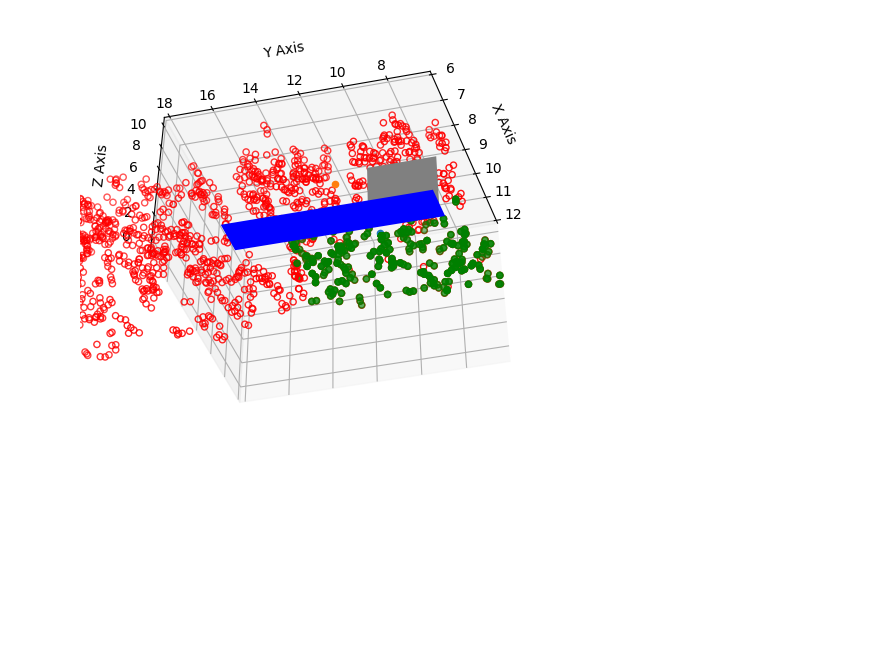

KeyboardInterrupt: 

In [325]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

index_rem = 0

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 20 == 0:
        ax.clear()
        
        # check if any fruit was picked at this time
        if fruit_removal[3, index_rem] < time_of_loop:
            # add the fruit index to be plotted
            index_plt = index_rem
            index_rem += 1
        
        ax.scatter(sortedFruit[0,:], sortedFruit[1,:], sortedFruit[2,:], facecolors='none', edgecolors='r')
        ax.scatter(fruit_removal[0,:index_rem], fruit_removal[1,:index_rem], fruit_removal[2,:index_rem], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0].z_edges_f)

        
        for count in range(num_arms):
            ax.scatter(a[count].qax[run], a[count].qay[run], a[count].qaz[run])

        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.001)
       
    
    
fig.show()

